#### Imports

In [1]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import json
import pandas as pd
import seaborn as sns
from enum import Enum
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import intersection.first_bin_search
import intersection.chunk_bbox_intersection
from bench_utils import parse_intersection_data 
common_bbox = intersection.chunk_bbox_intersection.common_bbox
chunk_bbox_is_intersecting = intersection.chunk_bbox_intersection.is_intersecting
chunk_bbox_intersection = intersection.chunk_bbox_intersection.intersection



from intersection.plotting import *
import algos.fpd_extended_lib.cfg as cfg
from algos.alg_fpd_extended import FpdExtended


pd.options.mode.chained_assignment = None  # default='warn'

#### Import data

In [2]:
fpd = FpdExtended()

# Geometries
# manual_data, _ = parse_intersection_data("manual")
# special_cases, _ = parse_intersection_data("latest_export.json", strip_precision=True)
world_data, world_data_stats = parse_intersection_data("world.json",40, strip_precision=True)
lund_data, lund_data_stats = parse_intersection_data("lund.json")
# sweden_data, sweden_data_stats = parse_intersection_data("sweden-places-a.json",40)
# new_york_data, new_york_data_stats = parse_intersection_data("new-york-natural.json",40)
# waterways_data, waterways_data_stats = parse_intersection_data("nord-est-waterways.json",40)

sweden_all_data, sweden_all_data_stats = parse_intersection_data("final/latest_export.pkl")
country_borders_data, country_borders_data_stats = parse_intersection_data("final/country_borders.pkl")
china_water_data, china_water_data_stats = parse_intersection_data("final/china_water_100k.pkl")

datasets = [
    (sweden_all_data, 13, "Sweden All"),
    (china_water_data, 13, "China Water"),
    (country_borders_data, 13, "Country Borders"),
    # (manual_data, 3, "manual_data"),
    # (special_cases, 3, "special_cases"),
    #(world_data, 15, "world_data"),
    (lund_data, 3, "lund_data"),
    # (sweden_data, 15, "sweden_data"),
    # (new_york_data, 10, "new_york_data"),
    # (waterways_data, 3, "waterways")
]


#### Constants

In [3]:
# Number of total iterations = NBR_ITER * N * number_of_datasets
NBR_ITER = -1 # Number of iterations for each dataset
N = 1 # Number of times to recalculate each geometry for reliable mean value
K = 5000

# Max DELTA_SIZE_VALUE in MAX_NUM_DELTAS Analysis
MAX_DELTA_SIZE = 100

#Geometry classification sizes
MEDIUM_THRESHOLD = 30
LARGE_THRESHOLD = 100


SAVE_DFS = True
USE_EXISTING_DF = True

## Functions Section

#### Config Setter Functions

In [4]:
def set_max_num_delta(val):
        cfg.MAX_NUM_DELTAS = val
        cfg.D_CNT_SIZE = cfg.required_bits(val)

def act_deact_baseline(activate=True):
        cfg.BASELINE_ON = activate
        cfg.DISABLE_OPTIMIZED_INTERSECTION = False if not activate else True
        cfg.DISABLE_OPTIMIZED_ADD_VERTEX = False if not activate else True
        cfg.DISABLE_OPTIMIZED_BOUNDING_BOX = False if not activate else True

#### Stats Collector Functions

In [5]:
def get_size_category(size):
    if size < LARGE_THRESHOLD and size >= MEDIUM_THRESHOLD:
            return "Medium", 1
    elif size >= LARGE_THRESHOLD:
         return "Large", 2
    else:
         return "Small", 0
    
def get_intersection_category(size1, size2):
    size1_cat, type1 = get_size_category(size1)
    size2_cat, type2 = get_size_category(size2)

    if type1 <= type2:
        return size1_cat + "/" + size2_cat
    return size2_cat + "/" + size1_cat


def get_context_category(g1, g2, bins=None):
    if bins == None:
        _, b1_fpde = fpd.compress(g1)
        _, b2_fpde = fpd.compress(g2) 
    else:
        b1_fpde, b2_fpde = bins

    bbox = common_bbox((b1_fpde, b2_fpde))
    intersects = shapely.intersects(g1, g2)
    contains = shapely.contains(g1, g2) or shapely.contains(g2, g1)
    if not bbox:
        return "No Overlap (FALSE)"
    elif not intersects:
        return "Overlap (FALSE)"
    elif not contains:
        return "Partial Overlap (TRUE)"
    else:
        return "Fully Inside Other (TRUE)"

def get_category_stat(g1, g2):
        s1, s2 = (shapely.get_num_coordinates(g1), shapely.get_num_coordinates(g2))
        size_category = get_intersection_category(s1, s2)
        context_category = get_context_category(g1, g2)
        return [size_category, context_category]


#For taking mean of all stats, not just total time
def get_time_stat(bins, predicate=False):
    alg = chunk_bbox_is_intersecting if predicate else chunk_bbox_intersection
    # 'decomp', 'nbr_recieved_chks', 'nbr_total_chks', 'total_time'
    mean_stat = [0, 0, 0, 0]
    for _ in range(N):
        stat, _ = alg(bins, get_stats=True)
        mean_stat = [sum(x) for x in zip(mean_stat, stat)]
    
    return [num / N for num in mean_stat]


#### Dataset Evaluation

In [6]:
def evaluate_dataset(stats_df, delta_size=None, not_predicate=True, add_size=False, dataset_name="", args=None):
        idx, g1, g2 = args
        if delta_size != None:
            set_max_num_delta(delta_size)
        bins = (fpd.compress(g1)[1], fpd.compress(g2)[1])

        for is_predicate in [False] if not_predicate else [True, False]:
            stats = []
            stats.extend(get_time_stat(bins=bins, predicate=is_predicate))
            stats.extend(get_category_stat(g1, g2))
            stats.append(delta_size if delta_size != None else cfg.MAX_NUM_DELTAS)
            if is_predicate:
                print(is_predicate)
            stats.append(is_predicate)
            stats.append(idx)
            stats.append(cfg.BASELINE_ON)
            if add_size:
                stats.append(len(bins[0]) + len(bins[1]))
            stats.append(dataset_name)
            stats_df.loc[len(stats_df)] = stats

# Statistics Visualization

#### Best MAX_NUM_DELTAS per Dataset Analysis

In [7]:
from tqdm import tqdm

if not USE_EXISTING_DF:
    #For baseline
    max_deltas_dfs = []
    for dataset in datasets:
        max_deltas_df = pd.DataFrame(columns=['decomp', 'nbr_recieved_chks', 'nbr_total_chks', 'total_time', "sizes", "context", "delta_size", "predicate", "dataset_idx", "baseline", "sum_size", "dataset"])

        dataset, _, dataset_name = dataset
        np.random.seed(2021)
        indicies = np.random.choice(len(dataset), size= min(K, len(dataset))) 
        dataset = np.array(dataset)[indicies] 
        for idx, (g1, g2) in enumerate(tqdm(dataset)):
            
            if g1.geom_type == "Point" or g2.geom_type == "Point":
                continue

            cat =  get_category_stat(g1, g2)[0]
            if cat != 'Small/Small' and cat != 'Medium/Medium' and cat != 'Large/Large':
                continue

            act_deact_baseline(activate=False)        
            for max_delta_size in range(0,MAX_DELTA_SIZE):
                evaluate_dataset(stats_df=max_deltas_df, delta_size=max_delta_size, not_predicate=True, add_size=True, dataset_name=dataset_name, args=(idx, g1, g2)) 

            act_deact_baseline(activate=True)        
            evaluate_dataset(stats_df=max_deltas_df, delta_size=10000000, not_predicate=True, add_size=True, dataset_name=dataset_name, args=(idx, g1, g2)) 
        
        max_deltas_df.to_csv(f'max_deltas_{dataset_name}.csv', index=False)
        max_deltas_dfs.append(max_deltas_df)
    max_deltas_df = pd.concat(max_deltas_dfs)
    display(max_deltas_df)

else:
    country_max_deltas_df = pd.read_csv('max_deltas_Country Borders3.csv')
    country_max_deltas_df['delta_size'] = country_max_deltas_df['delta_size'].replace(100000, 10000000)
    china_max_deltas_df = pd.read_csv('max_deltas_China Water3.csv')
    sweden_max_deltas_df = pd.read_csv('max_deltas_Sweden All3.csv')
    lund_max_deltas_df = pd.read_csv('max_deltas_lund_data3.csv')

    max_deltas_df = pd.concat([china_max_deltas_df, 
                               sweden_max_deltas_df, 
                               lund_max_deltas_df, 
                               country_max_deltas_df
                               ])




In [8]:
max_deltas_filt_df = max_deltas_df[['total_time', 'sum_size', "sizes", "delta_size", "predicate", "baseline"]]

### Helper

In [9]:

import plotly.graph_objs as objs

def make_general_facet_title(fig, x_title, y_title, secondary=None, barplot=False, hbarplot=False):
    #Remove current axis titles
    for axis in fig.layout:
        if type(fig.layout[axis]) == objs.layout.XAxis:
            fig.layout[axis].title.text = ''

    for axis in fig.layout:
        if type(fig.layout[axis]) == objs.layout.YAxis:
            fig.layout[axis].title.text = '' 

    fig.add_annotation(
    dict(
        x=0.48 if not barplot else 0.5,
        y=-0.04 if not barplot else -0.17,  # adjust as needed
        showarrow=False,
        text=x_title,
        xref="paper",
        yref="paper",
        font=dict(size=20),
        xanchor="center", 
        yanchor="top"
    )
    )

    if secondary != None:
        fig.add_annotation(
        dict(
            x=1.01,  # adjust as needed
            y=0.5,
            showarrow=False,
            text=secondary,
            textangle=-90,  # to rotate the text for the vertical y-axis
            xref="paper",
            yref="paper",
            font=dict(size=20),
            xanchor="center",
            yanchor="middle"
        )
    )

    fig.add_annotation(
    dict(
        x=-0.07 if not barplot else -0.07,  # adjust as needed
        y=0.5,
        showarrow=False,
        text=y_title,
        textangle=-90,
        xref="paper",
        yref="paper",
        font=dict(size=20),
        xanchor="center",
        yanchor="middle"
    )
)

In [10]:
def plot_max_delta_size_speed(df, is_predicate=False, no_mixed=False, relative=False):
    if no_mixed:
        df = df[df['sizes'].isin(["Small/Small", "Medium/Medium", "Large/Large"])]



    specs_element = [{"secondary_y": True}] if no_mixed else [{"secondary_y": True}, {"secondary_y": True}]

    df = df[df['predicate'] == is_predicate]
    df = df.groupby(['delta_size', 'sizes', 'baseline']).mean()
    df.reset_index(inplace=True)
    
    sizes = dict(zip(list(df.sizes.unique()), range(len(df.sizes.unique()))))

    fig = make_subplots(rows=3, cols=1 if no_mixed else 2, 
                        subplot_titles=(list(map(lambda x: "Geometry Sizes=" + x.split('/')[0], sizes.keys()))), 
                        horizontal_spacing=0.08, 
                        vertical_spacing=0.07, 
                        #x_title="Max Chunk Size",  y_title="Mean Execution Time (s)", 
                        specs=[specs_element,
                              specs_element,
                              specs_element])
    
    #For not showing the same legend twice
    legend_showed = False

    for size in sizes.keys():
        curr_context_df = df[(df['sizes'] == size)]

        for is_baseline in [False] if relative else [True, False]:

            line = dict(color='blue' if is_baseline else 'red', dash='dash' if is_baseline else None)

            curr_df = curr_context_df[curr_context_df['baseline'] == is_baseline]
            baseline_formatting = "FPDE" if not is_baseline else "Baseline"

            if relative:
                baseline_value = curr_context_df[(curr_context_df['baseline'] == True) & (curr_context_df['delta_size'] == 10000000)]
                curr_df['total_time'] = curr_df['total_time'].divide(baseline_value.total_time.values[0], axis=0)
                

            curr_df["total_time"] = curr_df.sort_values(by='delta_size')['total_time'].rolling(window=3, min_periods=1).mean()

            fig.add_trace(go.Scatter(x=curr_df.delta_size.values, y= curr_df.total_time.values,
                                    mode='lines',
                                    line=line,
                                    showlegend=not legend_showed,
                                    name=f"{baseline_formatting}"),col=sizes[size] // 3 + 1 if no_mixed else 1, row=sizes[size] % 3 + 1,
                                    secondary_y=False)
            
            if not is_baseline:
                fig.add_trace(go.Scatter(x=curr_df.delta_size.values, y=curr_df.sum_size.values,
                                        mode='lines',
                                        line=dict(color='green', dash='dash'),
                                        showlegend=not legend_showed,
                                        name=f"Average size (bits)"),col=sizes[size] // 3 + 1 if no_mixed else 1, row=sizes[size] % 3 + 1,
                                        secondary_y=True)
                legend_showed = True

                mix_delta_size = curr_df.sort_values(by='total_time').delta_size.values[0]

                fig.add_vrect(x0=mix_delta_size - 1, x1=mix_delta_size + 1, col=sizes[size] // 3 + 1 if no_mixed else 1, row=sizes[size] % 3 + 1,
                annotation_text=f"Min={mix_delta_size}", annotation_position="inside",
                fillcolor="green", opacity=0.25, line_width=0, annotation = dict(textangle=-90, font=dict(size=16)))
    
    #For changing facet size
    # for annotation in fig['layout']['annotations']:
    #     annotation['font']['size'] = 18  # Set your desired font size here

    intersection_format = "Intersection" if not is_predicate else "IsIntersection"
    baseline_format = "" if not is_baseline else "(Baseline)"
    fig.update_layout(
                      title_x=0.5,
                      width=1000, 
                      height=1000, 
                      legend=dict(
                            yanchor="top",
                            y=-0.037,
                            xanchor="left",
                            x=0.7,
                            orientation="h",
                            font=dict(size=15),
                        ),
                        title=dict(
                            text=f'Relative Execution Time for {intersection_format} by Max Chunk Size {baseline_format}',
                            x=0.5,
                            font=dict(size=22)
                            )
                        )

    fig.update_annotations(font=dict(size=16)) 
    fig.update_annotations(font=dict(size=16))
    fig.update_yaxes(type="log", tickfont=dict(size=16))

    fig.update_xaxes(tickfont=dict(size=16))

    make_general_facet_title(fig, "Max Chunk Size", "Relative Mean Execution Time (%)", secondary="Mean Size (bits)")
   

    display(max_deltas_filt_df)
    fig.show()



In [11]:
plot_max_delta_size_speed(max_deltas_filt_df, is_predicate=False, no_mixed=True, relative=True)

,total_time,sum_size,sizes,delta_size,predicate,baseline
0,0.002065,4845,Medium/Medium,0,False,False
1,0.001002,3023,Medium/Medium,1,False,False
2,0.001081,2374,Medium/Medium,2,False,False
3,0.001098,2109,Medium/Medium,3,False,False
4,0.000834,1878,Medium/Medium,4,False,False
...,...,...,...,...,...,...
384401,0.000107,560,Small/Small,96,False,False
384402,0.000102,560,Small/Small,97,False,False
384403,0.000101,560,Small/Small,98,False,False
384404,0.000100,560,Small/Small,99,False,False


#### Dataset Stats Collection

In [12]:
if USE_EXISTING_DF:
    stats_dfs = []

    for dataset in datasets:
        stats_df = pd.DataFrame(columns=['decomp', 'nbr_recieved_chks', 'nbr_total_chks', 'total_time', "sizes", "context", "delta_size", "predicate", "dataset_idx", "baseline", "dataset"])

        dataset, _, dataset_name = dataset
        np.random.seed(2021)
        indicies = np.random.choice(len(dataset), size=10000, replace=True)
        dataset = np.array(dataset)[indicies] 
        for idx, (g1, g2) in enumerate(tqdm(dataset)):
            if g1.equals(g2):
                continue
            
            if g1.geom_type == "Point" or g2.geom_type == "Point":
                continue

            for baseline_on in [True, False]:
                act_deact_baseline(activate=baseline_on)
                

                evaluate_dataset(stats_df, delta_size=15 if not baseline_on else 10000000, dataset_name=dataset_name, args=(idx, g1, g2)) # Second param: PLOT?
        stats_df.to_csv(f'stats_df_{dataset_name}.csv', index=False)
        stats_dfs.append(stats_df)
    stats_df = pd.concat(stats_dfs)
else:
    country_stats_df = pd.read_csv('stats_df_Country Borders2.csv')
    china_stats_df = pd.read_csv('stats_df_China Water2.csv')
    sweden_stats_df = pd.read_csv('stats_df_Sweden All2.csv')
    lund_stats_df = pd.read_csv('stats_df_lund_data2.csv')

    stats_df = pd.concat([
        china_stats_df, 
        sweden_stats_df, 
        lund_stats_df, 
        country_stats_df
        ]
    )


100%|██████████| 10000/10000 [01:22<00:00, 121.83it/s]


#### Total Execution Time by Context

##### Bars

In [28]:
def plot_total_time_bars_relative(df, is_predicate=False, size_cat_excl=[], log_scale=True):
    display(df[(df['predicate'] == True)])
    df = df[(df['predicate'] == False)] #(df['sizes'].isin(["Small/Small", "Medium/Medium", "Large/Large"]))]
    #df.reset_index(inplace=True)
    baseline_df = df[df['baseline']]
    not_baseline_df = df[~df['baseline']]
 
    baseline_df.sort_values(by=['dataset', 'dataset_idx'])
    not_baseline_df.sort_values(by=['dataset', 'dataset_idx'])
    not_baseline_df['total_time_ratio'] = not_baseline_df['total_time'].values / baseline_df['total_time'].values
    df = not_baseline_df
    df['frac'] =(df["decomp"].div(df.total_time, axis=0))
    df = df.groupby(["baseline", "context", "sizes"])[['frac','total_time_ratio']].mean() 
    display(df)
    df.reset_index(inplace=True)
    df['decomp_ratio'] = (df["frac"].mul(df.total_time_ratio, axis=0))
    df['intersection_ratio'] = (df["total_time_ratio"].sub(df.decomp_ratio, axis=0))
    intersection_formatting = "Intersection" if not is_predicate else "Is_Intersection"
    df = pd.concat([df] * 2, ignore_index=True)

    new_column_values = (["Decompression"] * (len(df) // 2))
    new_column_values.extend((["Intersection"] * (len(df) // 2)))

    df['Stage'] = new_column_values
    df['time'] = df.apply(lambda x: x['decomp_ratio'] * 100 if x["Stage"] == "Decompression" else x['intersection_ratio'] * 100, axis=1)
    df = df[['time', 'context', 'sizes', 'Stage']]
    fig = px.bar(df, 
                       x="context", 
                       y="time", 
                       facet_col="sizes", 
                       color="Stage",
                       barmode='group',
                       log_y=log_scale, 
                       facet_col_spacing=0.1, 
                       title=f"Execution Time for {intersection_formatting} in Different Contexts & Sizes",
                       labels=dict(sizes="Geometry Sizes", context="Context", baseline="Baseline", Stage="Stage: "),
                       facet_col_wrap=3,
                       facet_row_spacing=0.1,
                       height=1000,
                       width=1000,
                       pattern_shape='Stage',
                       color_discrete_map={
                            'Decompression': 'rgb(169,234,184)',
                            'Intersection': 'rgb(255,183,180)',
                            'Country Borders': 'rgb(254,198,161)'
                        }
                       #text="time"
                       )
    fig.update_annotations(font=dict(size=16))
    make_general_facet_title(fig, "Bounding Box Context", "Relative Mean Execution Time (%)", barplot=True)
    #fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
    fig.update_yaxes(matches=None, showticklabels=True,  tickfont=dict(size=16), range=[0,105])
    fig.update_xaxes(tickfont=dict(size=16))
    #fig.update_traces(texttemplate='%{text:.2}%', textposition='inside', textfont=dict(color='white'))

    fig.update_layout(barmode="relative",
                      #title_x=0.5,
                      width=1200, 
                      height=1000, 
                      legend=dict(
                            yanchor="top",
                            y=1.15,
                            xanchor="left",
                            x=0.83,
                           #orientation="h",
                            font=dict(size=16),
                        ),
                        title=dict(
                            text=f'Mean Relative Execution Time for Intersection in Different Contexts',
                            
                            font=dict(size=22)
                            )
                        )

    for row in range(2):
        for col in range(3):
            fig.add_hline(y=100, line_dash="dot", row=row, col=col)

   
    fig.show()


In [29]:
total_time_df = stats_df[['context', 'total_time', 'sizes', 'baseline', 'predicate', 'decomp', 'dataset', 'dataset_idx']]
plot_total_time_bars_relative(total_time_df, is_predicate=False, size_cat_excl=[], log_scale=False) #

,context,total_time,sizes,baseline,predicate,decomp,dataset,dataset_idx


frac  total_time_ratio
baseline context                   sizes                                    
False    Fully Inside Other (TRUE) Large/Large    0.412119          0.608685
                                   Medium/Large   0.650561          0.251681
                                   Medium/Medium  0.390496          0.852918
                                   Small/Large    0.615114          0.232119
                                   Small/Medium   0.384348          0.702705
                                   Small/Small    0.354472          0.918763
         Overlap (FALSE)           Large/Large    0.626540          0.118129
                                   Medium/Large   0.495826          0.283746
                                   Medium/Medium  0.434962          0.589800
                                   Small/Large    0.463822          0.264986
                                   Small/Medium   0.381938          0.579955
                                   Small/Small    0.387121          0.913274
         Partial Overlap (TRUE)    Large/Large    0.166713          0.455845
                                   Medium/Large   0.195442          0.545516
                                   Medium/Medium  0.177821          0.748335
                                   Small/Large    0.249962          0.489204
                                   Small/Medium   0.183370          0.847283
                                   Small/Small    0.170715          0.947331

In [15]:
def plot_total_time_bars(df, is_predicate=False, size_cat_excl=[], log_scale=True):
    df = df[(df['predicate'] == is_predicate)] #(df['sizes'].isin(["Small/Small", "Medium/Medium", "Large/Large"]))]
    df = df.groupby(['context', 'baseline', 'sizes']).mean()
    display(df)
    df.reset_index(inplace=True)
   
    intersection_formatting = "Intersection" if not is_predicate else "Is_Intersection"
    fig = px.histogram(df, 
                       x="context", 
                       y="total_time", 
                       facet_col="sizes", 
                       color="baseline",
                       barmode='group',
                       log_y=False, 
                       facet_col_spacing=0.1, 
                       histfunc="avg", 
                       title=f"Execution Time for {intersection_formatting} in Different Contexts & Sizes",
                       labels=dict(sizes="Geometry Sizes", context="Context", baseline="Baseline", Stage="Stage: "),
                       facet_col_wrap=3,
                       facet_row_spacing=0.1,
                       height=1000,
                       width=1000,
                       color_discrete_map={
                            True: 'rgb(169,234,184)',
                            False: 'rgb(255,183,180)',
                        }
                       #text="time"
                       )
    fig.update_annotations(font=dict(size=16))
    make_general_facet_title(fig, "Bounding Box Context", "Mean Execution Time (s)", barplot=True)
    #fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
    fig.update_yaxes(matches=None, showticklabels=True,  tickfont=dict(size=16))
    fig.update_xaxes(tickfont=dict(size=16))
    #fig.update_traces(texttemplate='%{text:.2}%', textposition='inside', textfont=dict(color='white'))

    fig.update_layout(barmode="group",
                      #title_x=0.5,
                      title_y=0.96,
                      width=1200, 
                      height=1000, 
                      
                      legend=dict(
                            yanchor="top",
                            y=1.15,
                            xanchor="left",
                            x=0.91,
                           #orientation="h",
                            font=dict(size=16),
                        ),
                        title=dict(
                            text=f'Mean Execution Time for Intersection in Different Contexts',
                            
                            font=dict(size=22)
                            )
                        )
    

   
    fig.show()

In [16]:
total_time_df = stats_df[['context', 'total_time', 'sizes', 'baseline', 'predicate', 'decomp']]
plot_total_time_bars(total_time_df, is_predicate=False, size_cat_excl=[], log_scale=False) #

total_time  predicate   
context                   baseline sizes                                  
Fully Inside Other (TRUE) False    Large/Large      0.043915        0.0  \
                                   Medium/Large     0.002511        0.0   
                                   Medium/Medium    0.001598        0.0   
                                   Small/Large      0.002106        0.0   
                                   Small/Medium     0.000567        0.0   
                                   Small/Small      0.000498        0.0   
                          True     Large/Large      0.092737        0.0   
                                   Medium/Large     0.030129        0.0   
                                   Medium/Medium    0.001919        0.0   
                                   Small/Large      0.025868        0.0   
                                   Small/Medium     0.000892        0.0   
                                   Small/Small      0.000607        0.0   
Overlap (FALSE)           False    Large/Large      0.001264        0.0   
                                   Medium/Large     0.000863        0.0   
                                   Medium/Medium    0.000479        0.0   
                                   Small/Large      0.000700        0.0   
                                   Small/Medium     0.000328        0.0   
                                   Small/Small      0.000288        0.0   
                          True     Large/Large      0.009200        0.0   
                                   Medium/Large     0.007336        0.0   
                                   Medium/Medium    0.000846        0.0   
                                   Small/Large      0.005968        0.0   
                                   Small/Medium     0.000580        0.0   
                                   Small/Small      0.000337        0.0   
Partial Overlap (TRUE)    False    Large/Large      0.006591        0.0   
                                   Medium/Large     0.002474        0.0   
                                   Medium/Medium    0.001625        0.0   
                                   Small/Large      0.001882        0.0   
                                   Small/Medium     0.001153        0.0   
                                   Small/Small      0.000719        0.0   
                          True     Large/Large      0.018036        0.0   
                                   Medium/Large     0.004888        0.0   
                                   Medium/Medium    0.002216        0.0   
                                   Small/Large      0.006731        0.0   
                                   Small/Medium     0.001404        0.0   
                                   Small/Small      0.000812        0.0   

                                                    decomp  
context                   baseline sizes                    
Fully Inside Other (TRUE) False    Large/Large    0.022955  
                                   Medium/Large   0.001715  
                                   Medium/Medium  0.000444  
                                   Small/Large    0.001738  
                                   Small/Medium   0.000215  
                                   Small/Small    0.000173  
                          True     Large/Large    0.016609  
                                   Medium/Large   0.028793  
                                   Medium/Medium  0.000685  
                                   Small/Large    0.024744  
                                   Small/Medium   0.000469  
                                   Small/Small    0.000265  
Overlap (FALSE)           False    Large/Large    0.000553  
                                   Medium/Large   0.000551  
                                   Medium/Medium  0.000209  
                                   Small/Large    0.000398  
                                   Small/Medium   0.000131  
                                   Small

baseline  context                    sizes        
False     Fully Inside Other (TRUE)  Large/Large      41.211938
                                     Medium/Large     65.056097
                                     Medium/Medium    39.049614
                                     Small/Large      61.511421
                                     Small/Medium     38.434834
                                     Small/Small      35.447174
          Overlap (FALSE)            Large/Large      62.654048
                                     Medium/Large     49.582579
                                     Medium/Medium    43.496202
                                     Small/Large      46.382173
                                     Small/Medium     38.193752
                                     Small/Small      38.712126
          Partial Overlap (TRUE)     Large/Large      16.671349
                                     Medium/Large     19.544162
                                     Medium/Medium   

total_time    decomp
baseline context                   sizes                              
False    Fully Inside Other (TRUE) Large/Large      0.043915  0.022955
                                   Medium/Large     0.002511  0.001715
                                   Medium/Medium    0.001598  0.000444
                                   Small/Large      0.002106  0.001738
                                   Small/Medium     0.000567  0.000215
                                   Small/Small      0.000498  0.000173
         Overlap (FALSE)           Large/Large      0.001264  0.000553
                                   Medium/Large     0.000863  0.000551
                                   Medium/Medium    0.000479  0.000209
                                   Small/Large      0.000700  0.000398
                                   Small/Medium     0.000328  0.000131
                                   Small/Small      0.000288  0.000112
         Partial Overlap (TRUE)    Large/Large      0.006591  0.000882
                                   Medium/Large     0.002474  0.000563
                                   Medium/Medium    0.001625  0.000266
                                   Small/Large      0.001882  0.000631
                                   Small/Medium     0.001153  0.000197
                                   Small/Small      0.000719  0.000117
True     Fully Inside Other (TRUE) Large/Large      0.092737  0.016609
                                   Medium/Large     0.030129  0.028793
                                   Medium/Medium    0.001919  0.000685
                                   Small/Large      0.025868  0.024744
                                   Small/Medium     0.000892  0.000469
                                   Small/Small      0.000607  0.000265
         Overlap (FALSE)           Large/Large      0.009200  0.007873
                                   Medium/Large     0.007336  0.006799
                                   Medium/Medium    0.000846  0.000554
                                   Small/Large      0.005968  0.005419
                                   Small/Medium     0.000580  0.000349
                                   Small/Small      0.000337  0.000166
         Partial Overlap (TRUE)    Large/Large      0.018036  0.004571
                                   Medium/Large     0.004888  0.002204
                                   Medium/Medium    0.002216  0.000609
                                   Small/Large      0.006731  0.005003
                                   Small/Medium     0.001404  0.000396
                                   Small/Small      0.000812  0.000187

,decomp,nbr_recieved_chks,nbr_total_chks,total_time,sizes,context,delta_size,predicate,dataset_idx,baseline,dataset,frac
1097,0.165344,18.0,1345.0,0.165689,Large/Large,Fully Inside Other (TRUE),15,False,602,False,Sweden All,99.792169
13189,0.001521,16.0,163.0,0.002441,Large/Large,Fully Inside Other (TRUE),15,False,7256,False,Sweden All,62.313757
14223,0.010165,216.0,376.0,0.121979,Large/Large,Fully Inside Other (TRUE),15,False,7828,False,Sweden All,8.333623
15275,0.001137,11.0,78.0,0.001821,Large/Large,Fully Inside Other (TRUE),15,False,8398,False,Sweden All,62.466133
16479,0.000790,9.0,91.0,0.001095,Large/Large,Fully Inside Other (TRUE),15,False,9071,False,Sweden All,72.129700
2889,0.001344,29.0,97.0,0.014213,Large/Large,Fully Inside Other (TRUE),15,False,1455,False,China Water,9.453373
3869,0.002178,51.0,56.0,0.028971,Large/Large,Fully Inside Other (TRUE),15,False,1951,False,China Water,7.517109
15967,0.001162,23.0,65.0,0.015113,Large/Large,Fully Inside Other (TRUE),15,False,8065,False,China Water,7.689643


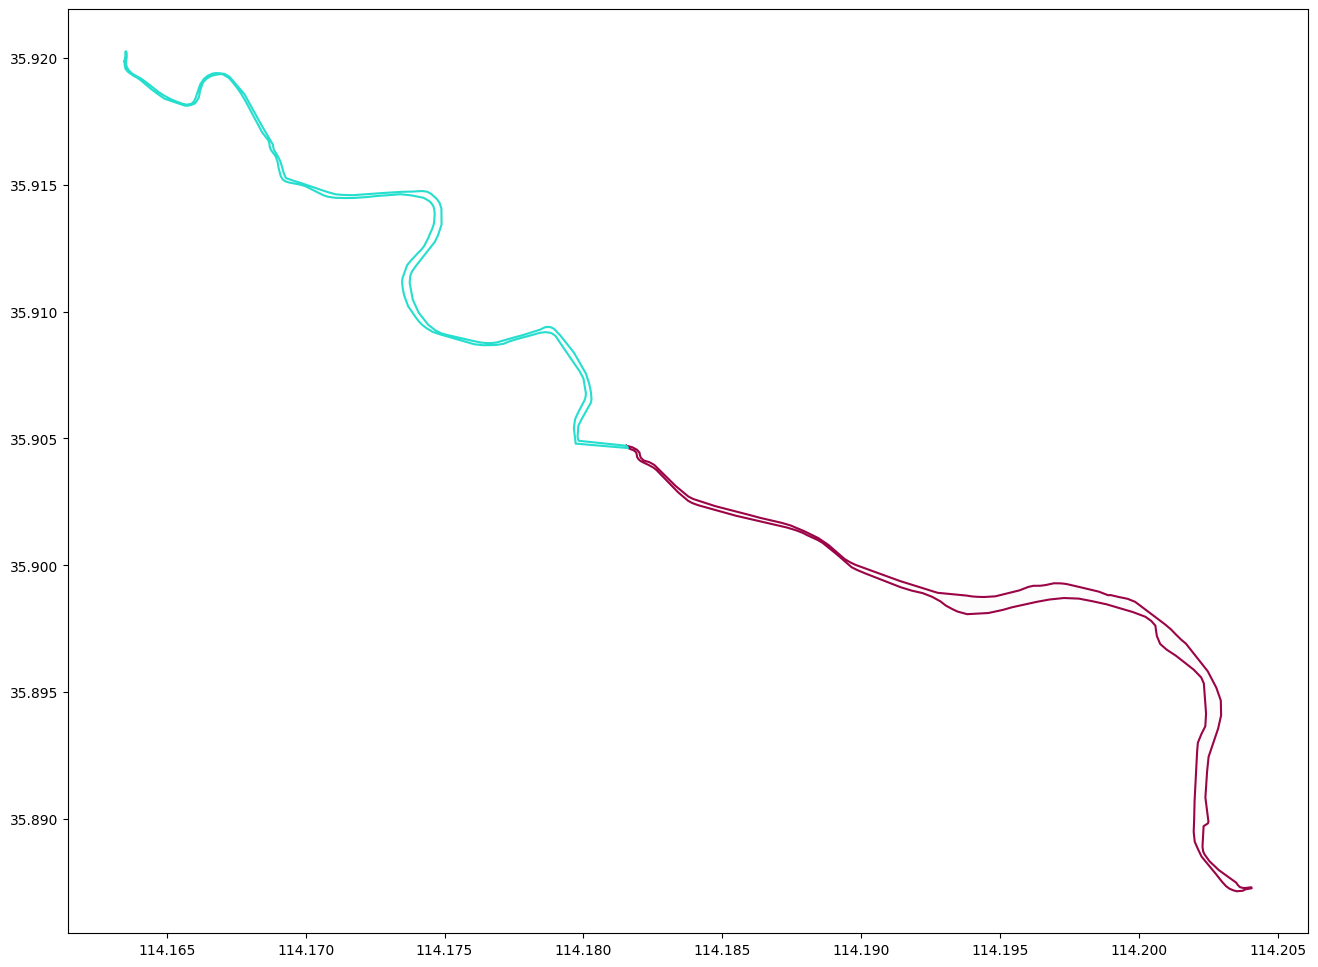

In [25]:
def get_percentage_cases(df, is_predicate=False):
    df = df[(df['predicate'] == is_predicate) & (df['baseline'] == False)] #(df['sizes'].isin(["Small/Small", "Medium/Medium", "Large/Large"]))]
    df = df.groupby(['context', 'sizes']).count()
    return df, sum(df['dataset'])
df, cnt = get_percentage_cases(stats_df)
df = 100 * df / (cnt)
#display(df['dataset'])

stats_df = stats_df[(stats_df['predicate'] == False)] #(df['sizes'].isin(["Small/Small", "Medium/Medium", "Large/Large"]))]

stats_df['frac'] =(stats_df["decomp"].div(stats_df.total_time, axis=0) * 100)
display(stats_df.groupby(["baseline", "context", "sizes"])['frac'].mean())
display(stats_df.groupby(["baseline", "context", "sizes"])[['total_time', 'decomp']].mean())

display(stats_df[(stats_df['context'] == "Fully Inside Other (TRUE)") & (stats_df['baseline'] == False) & (stats_df['sizes'] == "Large/Large")])


dataset, _, dataset_name = datasets[1]
np.random.seed(2021)
indicies = np.random.choice(len(dataset), size=10000, replace=True)
dataset = np.array(dataset)[indicies] 
g1, g2 = dataset[5255]
create_canvas()
plot_geometry(g1)
plot_geometry(g2)
plt.show()





#### Chunk Unfolding Analyzation

In [18]:
chunk_unfolded_df = stats_df[['nbr_recieved_chks', 'nbr_total_chks','predicate','baseline', 'context', 'sizes']]
chunk_unfolded_df["chk_fraction_unfolded"] = chunk_unfolded_df["nbr_recieved_chks"].div(chunk_unfolded_df.nbr_total_chks, axis=0) * 100

In [19]:
def plot_chunk_unfolded_frac(df, is_predicate=False, is_baseline=False):
    df = df[df['baseline'] == False]
    #df["chk_fraction_unfolded"] = df["nbr_recieved_chks"].div(df.nbr_total_chks, axis=0) * 100
    #df = df[(df['predicate'] == is_predicate) & (df['sizes'].isin(["Small/Small", "Medium/Medium", "Large/Large"]))]
    

    df = df.groupby(['context', 'baseline', 'sizes']).mean()
    df.reset_index(inplace=True)



    intersection_format = "Intersection" if not is_predicate else "IsIntersection"

    fig = px.bar(df, 
                       x="chk_fraction_unfolded", 
                       y="context", 
                       facet_row="sizes", 
                       barmode='group',
                       facet_col_spacing=0.1, 
                       title=f"Fraction of Chunks Unfolded for {intersection_format}",
                       labels=dict(sizes="Geometry Sizes", context="Context", baseline="Baseline", Stage="Stage: "),
                       facet_col_wrap=1,
                       height=1000,
                       width=2000,
                       orientation="h",
                       text="chk_fraction_unfolded",
                       color_discrete_sequence=['rgb(255,183,180)']*len(df)
                       )
    
    fig.update_annotations(font=dict(size=16))
    fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
    fig.update_yaxes(showticklabels=True, visible=True,  tickfont=dict(size=16))
    fig.update_xaxes(tickfont=dict(size=16))
    fig.update_traces(texttemplate='%{text:.2f}%' ,textfont=dict(size=14))
    fig.update_layout(barmode="relative",
                      title_x=0.5,
                      width=1000, 
                      height=800, 
                      legend=dict(
                            yanchor="top",
                            y=1,
                            xanchor="left",
                            x=0.5,
                            orientation="h",
                            font=dict(size=16)
                        ),
                        title=dict(
                            text=f'Fraction of Chunks Unfolded for Intersection in Different Contexts and Geometry Sizes',
                            x=0.5,
                            font=dict(size=22)
                            ),
                        annotations=[dict(                           
                            textangle=0
                            )
                        ],
                        margin=dict(
                        l=100,
                        r=200,
                        b=100,
                        t=100,
                        pad=5
                    )
                        )

    for axis in fig.layout:
        if type(fig.layout[axis]) == objs.layout.XAxis:
            fig.layout[axis].title.text = ''

    for axis in fig.layout:
        if type(fig.layout[axis]) == objs.layout.YAxis:
            fig.layout[axis].title.text = '' 

    fig.for_each_annotation(lambda a: a.update(text= "  " + a.text.split("=")[1]))
    #fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[0]))
    fig.add_annotation(
    dict(
        x=0.5,
        y=-0.04,  # adjust as needed
        showarrow=False,
        text="Chunks Unfolded (%)",
        xref="paper",
        yref="paper",
        font=dict(size=20),
        xanchor="center", 
        yanchor="top"
    )
    )

    fig.add_annotation(
    dict(
        x=1.3,
        y=0.62,  # adjust as needed
        showarrow=False,
        text="Geometry Size",
        xref="paper",
        yref="paper",
        textangle=90,
        font=dict(size=20),
        xanchor="center", 
        yanchor="top"
    )
    )

    fig.add_annotation(
    dict(
        x=-0.43,  # adjust as needed
        y=0.5,
        showarrow=False,
        text="Bounding Box Context",
        textangle=-90,
        xref="paper",
        yref="paper",
        font=dict(size=20),
        xanchor="center",
        yanchor="middle",
    ))
   
    fig.show()

## Results

#### Total time Analysis

#### (%) Unfolding of chunks

In [20]:
plot_chunk_unfolded_frac(chunk_unfolded_df, is_predicate=False, is_baseline=False)

In [21]:
def get_max_min_relative_speed(df):
    def calculate_ratio(x):
        base = x[x["baseline"] == True]['total_time']
        non_base = x[x["baseline"] == False]['total_time']
        if not base.empty and not non_base.empty:
            val = non_base.iloc[0] / base.iloc[0]
            return val
        else:
            return None

    df = df[stats_df['predicate'] == False]
    df_relative = df.groupby(["dataset_idx", "dataset"]).apply(calculate_ratio)

    df = df[~df['baseline']]
    df['total_time_ratio'] = df_relative.values
    maxes = df.sort_values(by='total_time_ratio',ascending=False).groupby(['context','sizes']).head(1)
    mins = df.sort_values(by='total_time_ratio',ascending=True).groupby(['context','sizes']).head(1)
    return mins, maxes

mins, maxes = get_max_min_relative_speed(stats_df)
print("_______________________\Lowest relative speed by context and size")
display(mins)
print("_______________________\nHighest relative speed by context and size")

display(maxes)


_______________________\Lowest relative speed by context and size


,decomp,nbr_recieved_chks,nbr_total_chks,total_time,sizes,context,delta_size,predicate,dataset_idx,baseline,dataset,frac,total_time_ratio
18759,0.000291,4.0,24.0,0.001478,Medium/Large,Partial Overlap (TRUE),15,False,9379,False,Country Borders,19.660262,0.001635
2821,0.000308,5.0,25.0,0.000658,Medium/Large,Overlap (FALSE),15,False,1421,False,China Water,46.752556,0.007499
17595,0.000093,2.0,2.0,0.000595,Small/Small,Partial Overlap (TRUE),15,False,8797,False,lund_data,15.647604,0.008744
10399,0.000227,3.0,28.0,0.000736,Large/Large,Partial Overlap (TRUE),15,False,5255,False,China Water,30.886054,0.009284
10007,0.000099,2.0,2.0,0.000275,Small/Small,Overlap (FALSE),15,False,5003,False,lund_data,36.145366,0.013057
13795,0.000048,0.0,8.0,0.000314,Medium/Medium,Overlap (FALSE),15,False,6897,False,Country Borders,15.197011,0.013824
5525,0.000173,0.0,88.0,0.000234,Large/Large,Overlap (FALSE),15,False,2762,False,Country Borders,74.073078,0.014560
831,0.000347,2.0,92.0,0.000566,Small/Large,Fully Inside Other (TRUE),15,False,451,False,Sweden All,61.243799,0.017064
12489,0.000026,0.0,7.0,0.000122,Small/Medium,Overlap (FALSE),15,False,6244,False,lund_data,21.268449,0.018736
17439,0.000157,2.0,5.0,0.000456,Small/Medium,Fully Inside Other (TRUE),15,False,9597,False,Sweden All,34.427180,0.018831


_______________________
Highest relative speed by context and size


,decomp,nbr_recieved_chks,nbr_total_chks,total_time,sizes,context,delta_size,predicate,dataset_idx,baseline,dataset,frac,total_time_ratio
1551,0.000085,2.0,2.0,0.000563,Small/Small,Partial Overlap (TRUE),15,False,846,False,Sweden All,15.040420,40.720554
10125,0.003300,2.0,1329.0,0.003593,Small/Large,Fully Inside Other (TRUE),15,False,5578,False,Sweden All,91.856698,13.024765
3163,0.000135,3.0,4.0,0.000425,Small/Medium,Overlap (FALSE),15,False,1739,False,Sweden All,31.759258,6.457152
12213,0.000249,4.0,23.0,0.000521,Large/Large,Overlap (FALSE),15,False,6170,False,China Water,47.852476,4.752617
8245,0.000115,2.0,3.0,0.000277,Small/Small,Overlap (FALSE),15,False,4122,False,lund_data,41.685556,4.603023
16161,0.000242,4.0,33.0,0.000925,Large/Large,Partial Overlap (TRUE),15,False,8080,False,Country Borders,26.120762,4.107310
15745,0.000263,5.0,11.0,0.002438,Medium/Medium,Partial Overlap (TRUE),15,False,7872,False,Country Borders,10.788770,3.553869
14995,0.000217,3.0,37.0,0.000908,Medium/Large,Partial Overlap (TRUE),15,False,7497,False,Country Borders,23.882771,3.053777
18447,0.000196,3.0,3.0,0.000826,Small/Medium,Partial Overlap (TRUE),15,False,9317,False,China Water,23.726927,2.823066
1827,0.000228,2.0,38.0,0.000473,Small/Large,Overlap (FALSE),15,False,998,False,Sweden All,48.250695,2.800612
